In [21]:
# 引入torch相关模块
import torch
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import init

# 引入初始化文件中的相关内容
from seqInit import toTs
from seqInit import input_size
from seqInit import train, real

# 引入画图工具
import numpy as np
import matplotlib.pyplot as plt

In [26]:
# 定义GRU模型
class gruModel(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, hidden_layer):
        super().__init__()
        self.gru = nn.GRU(in_dim, hidden_dim, hidden_layer,batch_first=True)
        self.fc = nn.Linear(hidden_dim, out_dim)

    def forward(self, x):
        out, _ = self.gru(x)
        out = out[:,12:,:]
        out = self.fc(out)
        return out

In [35]:
# 输入维度为1，输出维度为1，隐藏层维数为5, 定义GRU层数为3
gru = gruModel(1, 5, 1, 3)  #增大层数，相当于多了几个GRU重合，能避免单一GRU的不确定性，最后的曲线能平滑

# 定义损失函数和优化函数
criterion = nn.MSELoss()
optimizer = optim.Adam(gru.parameters(), lr=1e-2)

# 处理输入
def create_dataset(dataset) :
    data = dataset.reshape(1, -1, 1)
    return torch.from_numpy(data)

trainX = create_dataset(train[:-1])   #train[:-1]是(119,1)，最后trainX是（1,119,1），由第1~119的数当trainX
trainY = create_dataset(train[1:])[:,12:,:]  #train[1:]是(119,1)，最后trainY是（1,107,1），由第14~120的数当trainY，与trainX错位表示有滞后性
print(trainX.shape, trainY.shape)

torch.Size([1, 119, 1]) torch.Size([1, 107, 1])


In [36]:
# 训练模型
frq, sec = 4000, 400
loss_set = []

for e in range(1, frq + 1) :
    inputs = trainX
    target = trainY
    #forward
    output = gru(inputs)
    loss = criterion(output, target)
    # update paramters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    #print training information
    print_loss = loss.item()
    loss_set.append((e, print_loss))
    if e % sec == 0 :
        print('Epoch[{}/{}], Loss: {:.5f}'.format(e, frq, print_loss))

Epoch[400/4000], Loss: 0.00202
Epoch[800/4000], Loss: 0.00152
Epoch[1200/4000], Loss: 0.00075
Epoch[1600/4000], Loss: 0.00049
Epoch[2000/4000], Loss: 0.00036
Epoch[2400/4000], Loss: 0.00025
Epoch[2800/4000], Loss: 0.00026
Epoch[3200/4000], Loss: 0.00016
Epoch[3600/4000], Loss: 0.00015
Epoch[4000/4000], Loss: 0.00012


In [39]:
gru = gru.eval()

# 预测结果并比较
px = real[:-1].reshape(1, -1, 1)                  #
px = torch.from_numpy(px)
ry = real[1:].reshape(-1)
py = gru(px).data
py = np.array(py).reshape(-1)
print(px.shape, py.shape, ry.shape)

torch.Size([1, 143, 1]) (131,) (143,)


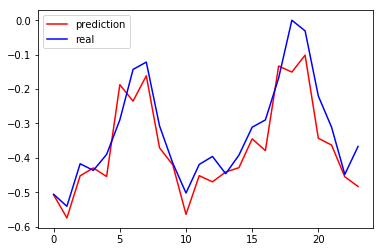

In [40]:
# 画出实际结果和预测的结果
plt.plot(py[-24:], 'r', label='prediction')
plt.plot(ry[-24:], 'b', label='real')
plt.legend(loc='best')